<a href="https://colab.research.google.com/github/DaanMoura/AprendizadoDeMaquina/blob/main/MovieDataset_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import copy

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/DaanMoura/AprendizadoDeMaquina/main/data/movies.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def get_date_year(date_column):
  try:
    return date_column.split('-')[0]
  except:
    return -1

def get_date_month(date_column):
  try:
    return date_column.split('-')[1]
  except:
    return -1

In [4]:
dataset['release_year'] = pd.Series(list(map(get_date_year, dataset["release_date"].tolist())))
dataset['release_month'] = pd.Series(list(map(get_date_month, dataset["release_date"].tolist())))

In [5]:
dataset.drop(["adult", "belongs_to_collection", "homepage", "id", "imdb_id", "original_title", "overview", "poster_path", "tagline", "title", "video","spoken_languages","release_date"], axis=1,inplace=True)
df = dataset.copy()

In [6]:
def get_first(o):
  try:
    return o.split(',')[0].split(':')[1].strip().strip("'")
  except:
    return -1
  

In [7]:
def get_first_number(o):
  try:
    id = o.split(',')[0].split(':')[1].strip().strip("'")
    if str(id).isnumeric():
      return id
    else:
      return -1
  except:
    return -1

In [8]:
pd.set_option('display.max_colwidth', -1)
df["production_companies"] = pd.Series(list(map(get_first, df["production_companies"].tolist())))
df["production_countries"] = pd.Series(list(map(get_first, df["production_countries"].tolist())))
df["genres"] = pd.Series(list(map(get_first_number, df["genres"].tolist())))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [9]:
colunas = ["original_language","production_companies","production_countries"]

In [10]:
labels, levels = pd.factorize(df['production_companies'])

In [11]:
string_columns = ['original_language','production_companies','production_countries','status']

for column in string_columns:
  labels, levels = pd.factorize(df[column])
  df[column] = labels

In [12]:
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(-1)

In [13]:
#separa o alvo e os dados
Y = df["vote_average"]
for i in range(len(Y)):
  if Y[i] < 2:
    Y[i] = 1
  elif Y[i] < 4:
    Y[i] = 2
  elif Y[i] < 6:
    Y[i] = 3
  elif Y[i] < 8:
    Y[i] = 4
  else:
    Y[i] = 5

X = df.drop(["vote_average"], axis = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib

In [14]:
#/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg'
dataset.drop([29503],axis=0,inplace=True)


In [15]:
#separa em teste e treino
x_tr, x_te, y_tr, y_te = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [30]:
def apply_grid_search(classifier, paramgrid):
  gs = GridSearchCV(classifier, param_grid=param_grid)
  gs.fit(x_tr,y_tr)
  print(gs.best_estimator_)
  return gs.best_estimator_

In [31]:
def fit_model(classifier):
  model = classifier.fit(x_tr, y_tr)
  y_pred = classifier.predict(x_te)
  print(accuracy_score(y_te, y_pred))
  return model

In [32]:
def confusion_matrix(model):
  titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
  for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, x_te, y_te,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

In [33]:
fit_model(DecisionTreeClassifier())

0.5404662414778976


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Hyperparams estimators

In [18]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': range(2,30,2),
              'min_samples_leaf': range(2,10,2),
              'min_impurity_decrease': np.linspace(0,0.5,10)}

In [ ]:
apply_grid_search(DecisionTreeClassifier(), param_grid)

In [ ]:
gs.best_estimator_

In [20]:
dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
classifier = dtc.fit(x_tr, y_tr)
y_pred = dtc.predict(x_te)
accuracy_score(y_te, y_pred)

0.6211787992082692

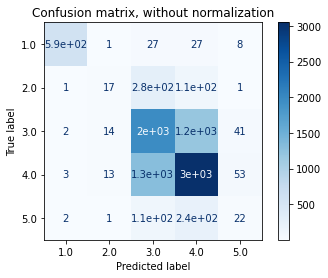

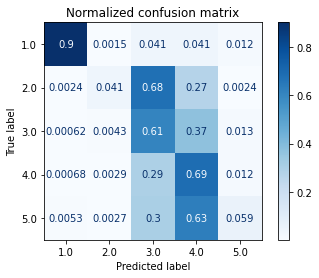

In [25]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, x_te, y_te,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)


With stratify

In [26]:
x_tr, x_te, y_tr, y_te = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state = 42)

In [27]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': range(2,30,2),
              'min_samples_leaf': range(2,10,2),
              'min_impurity_decrease': np.linspace(0,0.5,10)}

dtc = DecisionTreeClassifier()
gs = GridSearchCV(dtc, param_grid=param_grid)
gs.fit(x_tr,y_tr)

gs.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [28]:
dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
classifier = dtc.fit(x_tr, y_tr)
y_pred = dtc.predict(x_te)
accuracy_score(y_te, y_pred)

0.6074334726193095

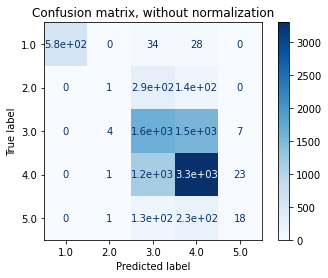

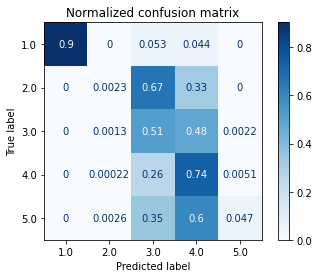

In [29]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, x_te, y_te,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)